# Python: Channels & colors

This section gives a brief overview of some color-related considerations when using Python.

> See the [scikit-image color module](https://scikit-image.org/docs/dev/api/skimage.color.html) for a lot more useful info.

In [1]:
# First, our usual default imports
import sys
sys.path.append('../../../')

from helpers import *
import matplotlib.pyplot as plt
import numpy as np

## RGB images

Let's begin by reading the RGB image used on the title page of this book.

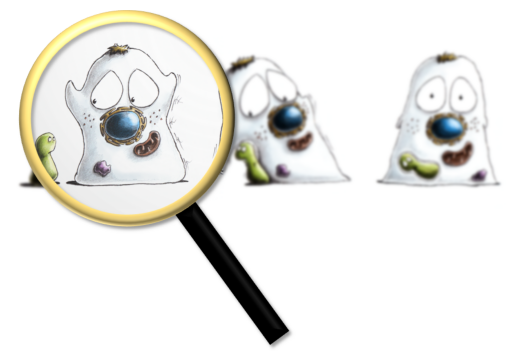

In [2]:
im = load_image('title_cells.png')

plt.imshow(im)
plt.axis(False)
plt.show()

If we check the shape of the image, we can see that the RGB information seems to be joined on at the end: the shape is in the form `[rows, columns, channels]`.

In [3]:
print(im.shape)

(600, 872, 3)


### RGB to single-channel

We can convert an RGB image to a single-channel image in lots of ways.

> A single-channel image is often referred to as **grayscale** - although whether it is actually displayed using shades of gray or not depends upon the colormap.

#### Split channels

One option is to split the RGB channels to give three separate single-channel images.

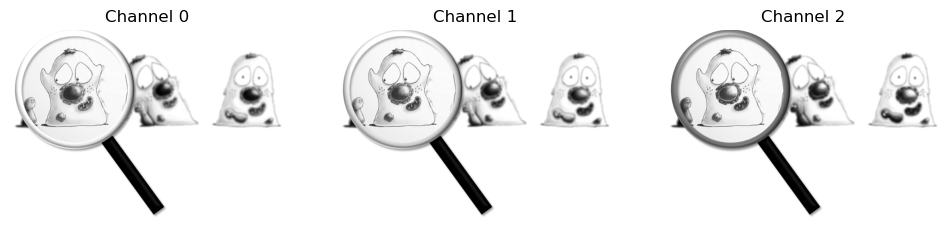

In [4]:
# Make a wider figure so we can fit in subplots
plt.figure(figsize=(12, 4))

# Show each of the three channels
for ii in range(3):
    
    # Subplot indices start at 1
    plt.subplot(1, 3, ii+1)
    
    # Array indices start at 0
    im_channel = im[..., ii]
    plt.imshow(im_channel, cmap='gray')
    plt.title(f'Channel {ii}')
    plt.axis(False)

plt.show()

#### Averaging channels

A second easy option is to simply calculate the average (mean) of the RGB values.

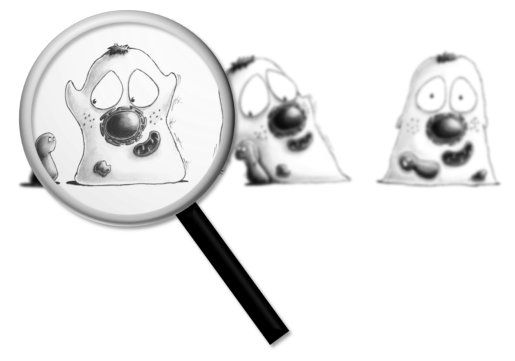

In [5]:
# Use axis=-1 to 'average along the last dimension'
# Here, I could also have used im.mean(axis=2)
im_mean = im.mean(axis=-1)
plt.imshow(im_mean, cmap='gray')
plt.axis(False)
plt.show()

However, it is common to calculate a *weighted* mean of the RGB values.
Commonly the weights are

$$0.2125 R + 0.7154 G + 0.0721 B$$

This is what scikit-image's [`rgb2gray`](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2gray) does, as described [here](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html).

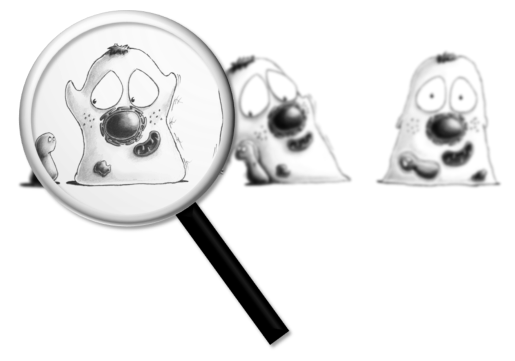

In [6]:
from skimage.color import rgb2gray

im_weighted_mean = rgb2gray(im)

plt.imshow(im_weighted_mean, cmap='gray')
plt.axis(False)
plt.show()

To be fair, the simple mean and the weighted mean images don't look very different to me.

To check if they really *are* different, we can show one subtracted from the other.

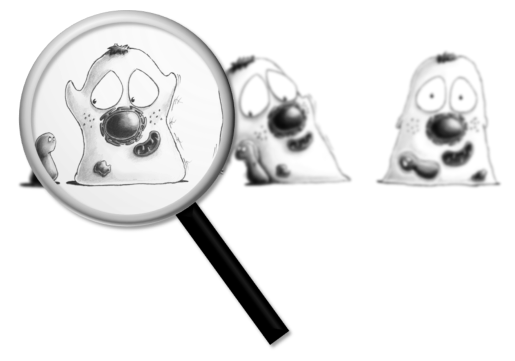

In [7]:
plt.imshow(im_mean - im_weighted_mean, cmap='gray')
plt.axis(False)
plt.show()

Hmmmmm, this looks very suspicious.
The fact the *difference* image looks the same suggests to me that some rescaling might have happened.

So let's go back to checking the `dtype` comparing statistics.

In [8]:
print(f'The mean of im is: {im.mean()} (dtype={im.dtype})')
print(f'The mean of im_mean is: {im_mean.mean()} (dtype={im_mean.dtype})')
print(f'The mean of im_weighted_mean is: {im_weighted_mean.mean()} (dtype={im_mean.dtype})')

The mean of im is: 232.17774592252803 (dtype=uint8)
The mean of im_mean is: 232.17774592252803 (dtype=float64)
The mean of im_weighted_mean is: 0.9143139910430533 (dtype=float64)


Right, that seems to suggest that `rgb2gray` has also rescaled our image during conversion.

Indeed, it's reasonably common to work with 8-bit RGB images in Python (`uint8`) with values in the range 0-255, but it's perhaps even more common to work with floating point RGB images in the range 0-1 (either `float32` or `float64`).
So we do need to be on the lookout for sneaky conversions.

With that in mind, we can make our images comparable my dividing our `im_mean` by 255.

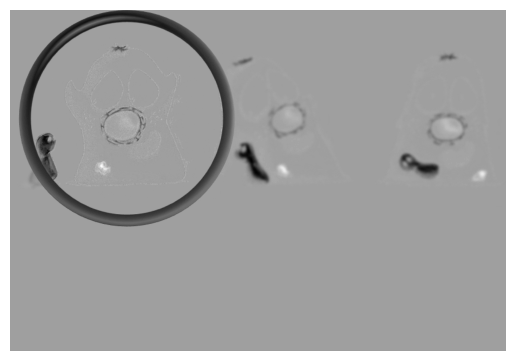

In [9]:
im_diff = im_mean/255.0 - im_weighted_mean
plt.imshow(im_diff, cmap='gray')
plt.axis(False)
plt.show()

This demonstrates that the pixel values are at least a bit different when converted using the weighted mean.

## Multichannel images

Working with multichannel (non-RGB) images in Python is extremely easy in some ways, and very awkward in others.

Although because most of the awkward stuff comes at the start, that will dominate the rest of this section.

For example, even just opening the data properly can be a challenge.


### Reading multichannel images

I like using [imageio](https://imageio.readthedocs.io/en/v2.9.0/userapi.html) to read images for its simplicity.
However, if we rely upon `imageio.imread` for a multichannel tiff, we tend to just get the first channel.

> Later chapters will show other ways to open images.

In [10]:
# The custom helper function effectively uses imageio.imread(path), 
# but has some extra logic to find the image & unzip it.
im = load_image('Rat_Hippocampal_Neuron.zip')

# This image should have 5 channels... let's see if it does
print(im.shape)

(5, 512, 512)


We can do better if we switch to `imageio.volread` to treat the image as a volume instead.

In [11]:
# This effectively uses imageio.volread(path)
im = load_image('Rat_Hippocampal_Neuron.zip', volume=True)

# Check the dimensions again
print(im.shape)

(5, 512, 512)


The trouble now is that the channels appear at the *start* of our shape, whereas for the RGB image the channels were at the end.

That may or may not matter - *because Python doesn't have a completely fixed convention for where the channels should be*.

Some libraries assume 'channels-first', and some assume 'channels-last'.

The good news is that, if you know what's required, you can easily move the channels to the right place.

In [12]:
im_channels_first = im.copy()
im_channels_last = np.moveaxis(im, 0, -1)

print(f'Channels first shape:\t {im_channels_first.shape}')
print(f'Channels last shape:\t {im_channels_last.shape}')

Channels first shape:	 (5, 512, 512)
Channels last shape:	 (512, 512, 5)


### Displaying multichannel images

Unfortunately, you can't easily show any arbitrary multichannel image using either channels-first or channels-last.

I knew this wouldn't work! Invalid shape (5, 512, 512) for image data
And this doesn't work either! Invalid shape (512, 512, 5) for image data


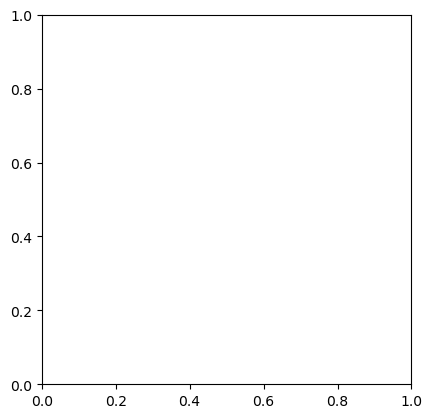

In [13]:
try:
    plt.imshow(im_channels_first)
except TypeError as err:
    print(f'I knew this wouldn\'t work! {err}')
    
try:
    plt.imshow(im_channels_last)
except TypeError as err:
    print(f'And this doesn\'t work either! {err}')

Let's focus on channels-last, since it's more similar to how the RGB images behaved.

We can show the channels one by one, as in the RGB case, or average the channels if we like - although the mean we get probably won't be a very meaningful mean.

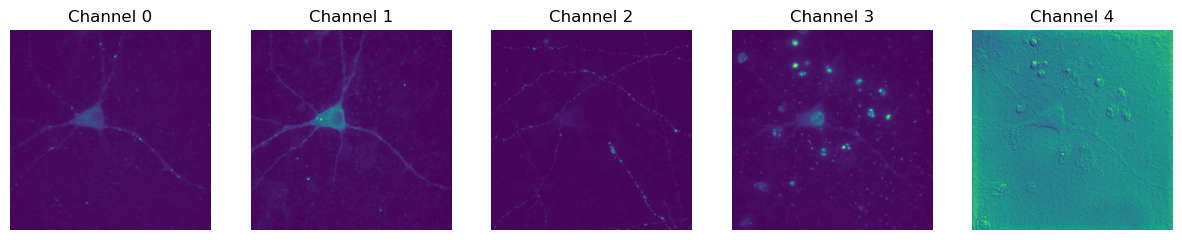

In [14]:
im = im_channels_last.copy()

# Make a wider figure so we can fit in subplots
plt.figure(figsize=(15, 6))

# Show each of the three channels
n_channels = im.shape[-1]
for ii in range(n_channels):
    
    # Subplot indices start at 1
    plt.subplot(1, n_channels, ii+1)
    
    # Array indices start at 0
    im_channel = im[..., ii]
    plt.imshow(im_channel)
    plt.title(f'Channel {ii}')
    plt.axis(False)

plt.show()

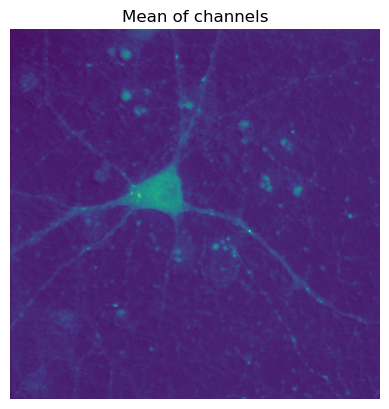

In [15]:
# Not a very meaningful mean - the pixel values in the channels mean quite different things, 
# so it doesn't make much sense to combine them in this way
plt.imshow(im.mean(axis=-1))
plt.title('Mean of channels')
plt.axis(False)
plt.show()

### Adding color

Unfortunately, we don't currently have any of the color information that could be used to display each channel.
We can just choose a colormap, like with any other single-channel image, but we can't easily visualize channels merged together (at least with matplotlib... as far as I know).

But one this we *can* do is convert each of our channels to RGB, using a fixed color.
Here is a helper function to do that.

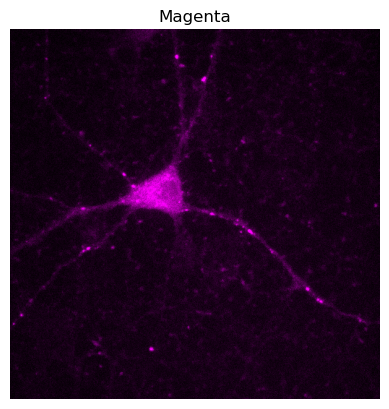

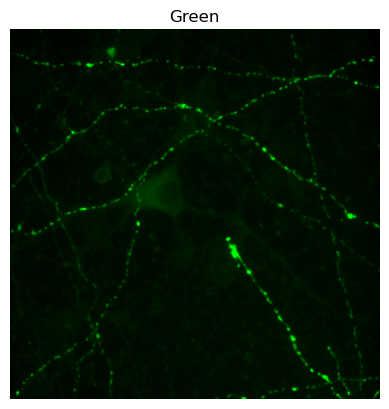

In [16]:
def colorize(im, color, clip_percentile=0.1):
    """
    Helper function to create an RGB image from a single-channel image using a 
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')
        
    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)
    
    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)
    
    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color
    
# The color we provide gives RGB values in order, between 0 and 1
im_red = colorize(im[..., 0], (1, 0, 1))
plt.imshow(im_red)
plt.axis(False)
plt.title('Magenta')
plt.show()

im_green = colorize(im[..., 2], (0, 1, 0))
plt.imshow(im_green)
plt.axis(False)
plt.title('Green')
plt.show()

### Creating composites

Having done that, we can simply add our RGB images together to create a composite image - remembering to clip the result, so that we keep inside the range 0-1.

> **Important!** We've moved away from colormaps here to change pixel values when creating RGB images. This gives us more control, but we need to remember that none of these modified images are suitable for quantitative analysis.

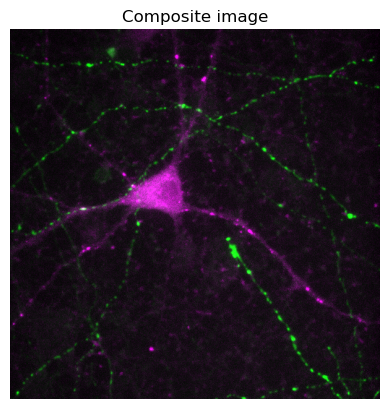

In [17]:
im_composite = np.clip(im_red + im_green, 0, 1)
plt.imshow(im_composite)
plt.title('Composite image')
plt.axis(False)
plt.show()